In [3]:
import matplotlib.pyplot as plt
import numpy as np
import mysg # Tom Robitaille's YSO grid tool
from astropy.table import Table

from astropy.io import fits
from astropy import units as u, constants
import pylab as pl
import requests

from icemodels import absorbed_spectrum, absorbed_spectrum_Gaussians, convsum, fluxes_in_filters, load_molecule, atmo_model, molecule_data
del molecule_data['h2o_b']

from astropy.visualization import simple_norm


In [4]:
cd ../smart-plotters

/blue/adamginsburg/savannahgramze/cloudc/smart-plotters/smart-plotters


In [5]:
from jwst_plots import JWSTCatalog, make_cat_use
from glimpse_plots import GlimpseCatalog
from cutout_plot import Cutout

In [6]:
cd ../notebooks

/blue/adamginsburg/savannahgramze/cloudc/smart-plotters/notebooks


In [7]:
import dust_extinction
from dust_extinction.averages import RRP89_MWGC, CT06_MWGC, F11_MWGC, G21_MWAvg
from dust_extinction.parameter_averages import CCM89
from astroquery.svo_fps import SvoFps


# Filter Abs

In [8]:
jfilts = SvoFps.get_filter_list('JWST')
jfilts.add_index('filterID')

In [9]:
instrument = 'NIRCam'
telescope = 'JWST'
filt466 = 'F466N'
#filt470 = 'F470N'
wavelength_table_466 = SvoFps.get_transmission_data(f'{telescope}/{instrument}.{filt466}')
#wavelength_table_470 = SvoFps.get_transmission_data(f'{telescope}/{instrument}.{filt470}')
wavelength_table_410 = SvoFps.get_transmission_data(f'{telescope}/{instrument}.F410M')
wavelength_table_405 = SvoFps.get_transmission_data(f'{telescope}/{instrument}.F405N')

wavelength_tables_jwst = {filt: SvoFps.get_transmission_data(f'{telescope}/{instrument}.{filt}')
                          for filt in ['F466N', 'F410M', 'F405N']}

Text(0, 0.5, 'Transmission')

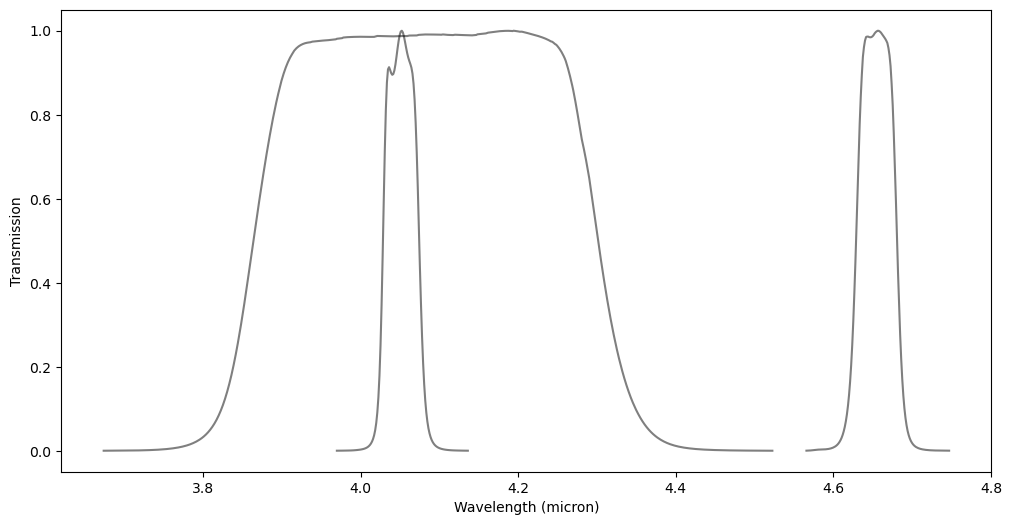

In [10]:
fig = plt.figure(figsize=(12, 6))

for filt, tbl in wavelength_tables_jwst.items():
    xarr = tbl['Wavelength'].quantity.to(u.micron)
    plt.plot(xarr, tbl['Transmission']/tbl['Transmission'].max(), color='k', alpha=0.5, label=filt)

plt.xlabel('Wavelength (micron)')
plt.ylabel('Transmission')

In [11]:
instrument = 'IRAC'
telescope = 'Spitzer'
wavelength_tables_spitzer = {filt: SvoFps.get_transmission_data(f'{telescope}/{instrument}.{filt}')
                             for filt in ['I1', 'I2', 'I3', 'I4']}

wavelength_tables = {#'f470n': wavelength_table_470,
                     'f466n': wavelength_table_466,
                     'f410m': wavelength_table_410,
                     'f405n': wavelength_table_405,
                    }
wavelength_tables.update(wavelength_tables_spitzer)

Text(0, 0.5, 'Transmission')

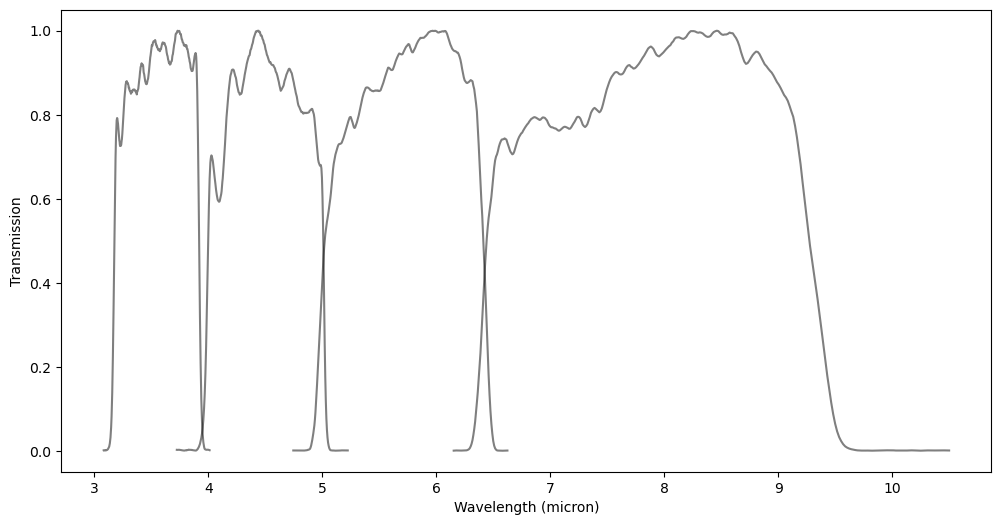

In [12]:
fig = plt.figure(figsize=(12, 6))

for filt, tbl in wavelength_tables_spitzer.items():
    xarr = tbl['Wavelength'].quantity.to(u.micron)
    plt.plot(xarr, tbl['Transmission']/tbl['Transmission'].max(), color='k', alpha=0.5, label=filt)

plt.xlabel('Wavelength (micron)')
plt.ylabel('Transmission')

In [13]:
instrument = 'WISE'
telescope = 'WISE'
wavelength_tables_wise = {filt: SvoFps.get_transmission_data(f'{telescope}/{instrument}.{filt}')
                          for filt in ['W1', 'W2', 'W3', 'W4']}

Text(0, 0.5, 'Transmission')

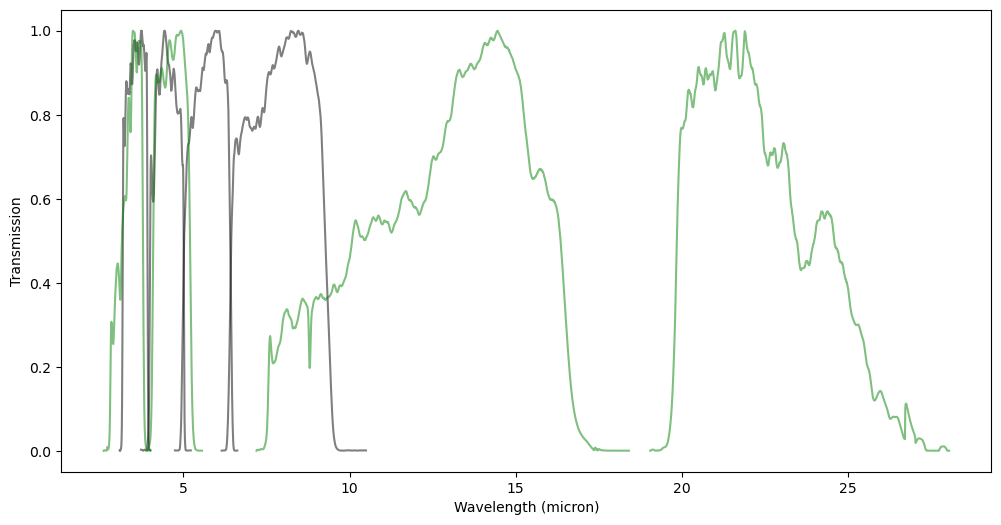

In [14]:
fig = plt.figure(figsize=(12, 6))

#for filt, tbl in wavelength_tables_jwst.items():
#    xarr = tbl['Wavelength'].quantity.to(u.micron)
#    plt.plot(xarr, tbl['Transmission']/tbl['Transmission'].max(), color='k', alpha=0.5, label=filt)

for filt, tbl in wavelength_tables_spitzer.items():
    xarr = tbl['Wavelength'].quantity.to(u.micron)
    plt.plot(xarr, tbl['Transmission']/tbl['Transmission'].max(), color='k', alpha=0.5, label=filt)

for filt, tbl in wavelength_tables_wise.items():
    xarr = tbl['Wavelength'].quantity.to(u.micron)
    plt.plot(xarr, tbl['Transmission']/tbl['Transmission'].max(), color='g', alpha=0.5, label=filt)

plt.xlabel('Wavelength (micron)')
plt.ylabel('Transmission')

Text(0, 0.5, 'Transmission')

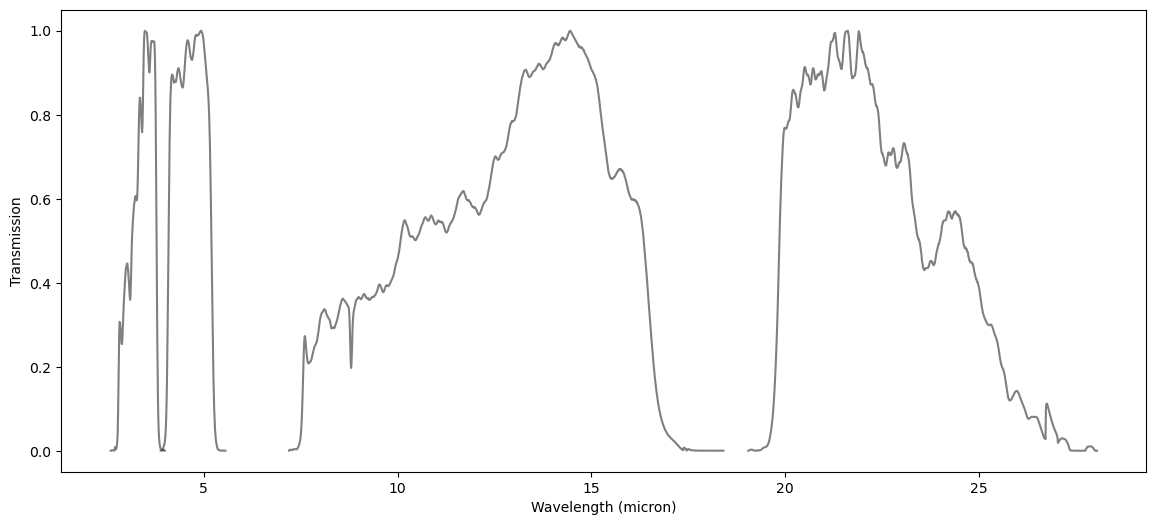

In [15]:
fig = plt.figure(figsize=(14, 6))

for filt, tbl in wavelength_tables_wise.items():
    xarr = tbl['Wavelength'].quantity.to(u.micron)
    plt.plot(xarr, tbl['Transmission']/tbl['Transmission'].max(), color='k', alpha=0.5, label=filt)

plt.xlabel('Wavelength (micron)')
plt.ylabel('Transmission')

In [16]:
instrument = '2MASS'
telescope = '2MASS'
wavelength_tables_2mass = {filt: SvoFps.get_transmission_data(f'{telescope}/{instrument}.{filt}')
                          for filt in ['J', 'H', 'Ks']}

Text(0, 0.5, 'Transmission')

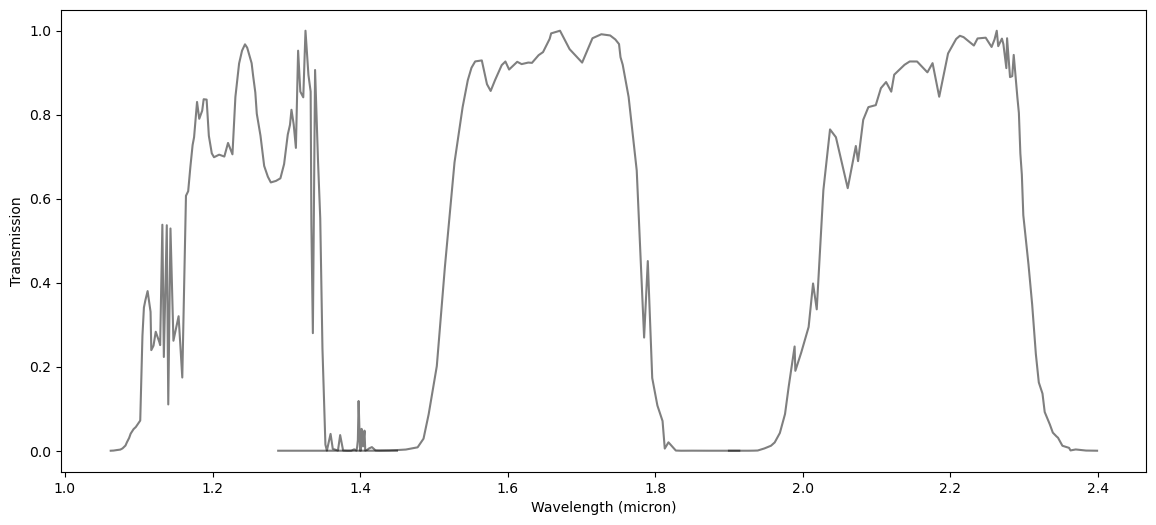

In [17]:
fig = plt.figure(figsize=(14, 6))

for filt, tbl in wavelength_tables_2mass.items():
    xarr = tbl['Wavelength'].quantity.to(u.micron)
    plt.plot(xarr, tbl['Transmission']/tbl['Transmission'].max(), color='k', alpha=0.5, label=filt)

plt.xlabel('Wavelength (micron)')
plt.ylabel('Transmission')

# Ice Absorption

In [18]:
import icemodels.core
import importlib as imp
imp.reload(icemodels.core)
from icemodels.core import (phx4000, absorbed_spectrum, absorbed_spectrum_Gaussians, convsum,
                            fluxes_in_filters,
                            univap_molecule_data,
                            load_molecule, load_molecule_ocdb, load_molecule_univap, read_ocdb_file,
                            atmo_model, molecule_data)
from astropy import log
log.setLevel('DEBUG')
ice_model_table = load_molecule_ocdb('ch3oh.10k')
log.setLevel('INFO')

DEBUG: molecule name = ch3oh.10k, ID=https://ocdb.smce.nasa.gov/dataset/78 [icemodels.core]


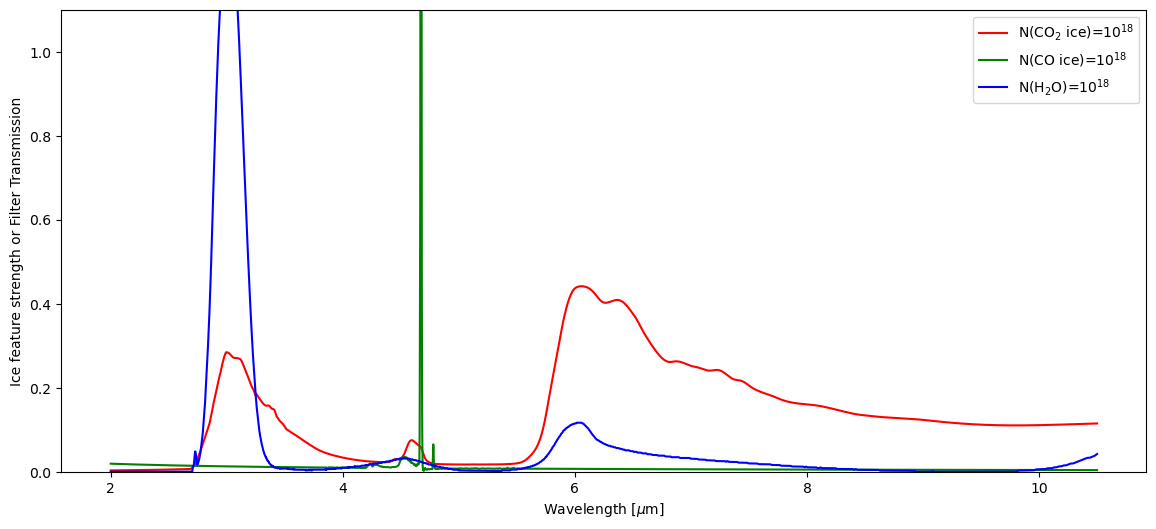

In [ ]:
fig = plt.figure(figsize=(14, 6))
xarr = np.linspace(2.0, 10.5, int(5e4))*u.um

mol = load_molecule_ocdb('co2')
mod = absorbed_spectrum(1e18*u.cm**-2, mol, return_tau=True, xarr=xarr)
plt.plot(xarr, mod, color='r', label='N(CO$_2$ ice)=10$^{18}$')

#mol = load_molecule_ocdb('co')
optical_constants_cache_dir = '/red/adamginsburg/repos/icemodels/icemodels/data/'
baratta_co = read_ocdb_file(f'{optical_constants_cache_dir}/1_CO_(1)_12.5K_Baratta.txt')
#mod = absorbed_spectrum(1e18*u.cm**-2, mol, return_tau=True, xarr=xarr)
mod = absorbed_spectrum(1e18*u.cm**-2, baratta_co, return_tau=True, xarr=xarr)
plt.plot(xarr, mod, color='g', label='N(CO ice)=10$^{18}$')

#mol = load_molecule_ocdb('h2o:ch3oh:co:nh3.100:10:1:1.10k')
#mol = load_molecule_ocdb('h2o.10k')
h2o = read_ocdb_file(f'{optical_constants_cache_dir}/107_H2O (1)_10K_Hudgins.txt')
mod = absorbed_spectrum(1e18*u.cm**-2, h2o, return_tau=True, xarr=xarr)
plt.plot(xarr, mod, color='b', label='N(H$_2$O)=10$^{18}$')

#mol = load_molecule_ocdb('ch3oh.10k')
#mod = absorbed_spectrum(1e18*u.cm**-2, mol, return_tau=True, xarr=xarr)
#plt.plot(xarr, mod, color='m', label='N(CH$_3$OH)=10$^{18}$')

plt.ylim(0,1.1)
plt.xlabel(f"Wavelength [$\\mu$m]")
plt.ylabel("Ice feature strength or Filter Transmission")
plt.legend()
# 3.6 - 5.8, would water ice affect these at all? 
# proof of concept finesst proposal 
# molecular hydrogen! 

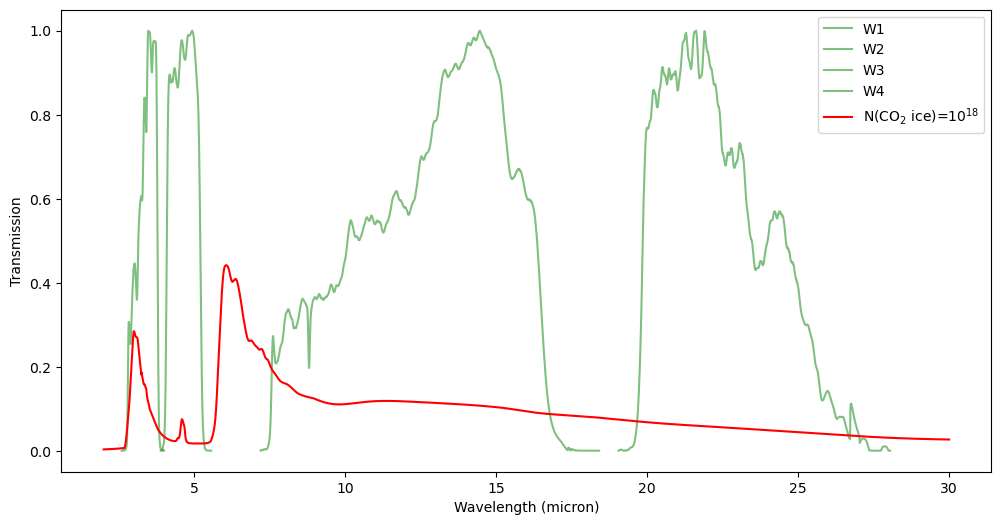

In [20]:
fig = plt.figure(figsize=(12, 6))

for filt, tbl in wavelength_tables_wise.items():
    xarr = tbl['Wavelength'].quantity.to(u.micron)
    plt.plot(xarr, tbl['Transmission']/tbl['Transmission'].max(), color='g', alpha=0.5, label=filt)

xarr = np.linspace(2.0, 30, int(5e4))*u.um
mol = load_molecule_ocdb('co2')
mod = absorbed_spectrum(1e18*u.cm**-2, mol, return_tau=True, xarr=xarr)
plt.plot(xarr, mod, color='r', label='N(CO$_2$ ice)=10$^{18}$')

plt.xlabel('Wavelength (micron)')
plt.ylabel('Transmission')
plt.legend()

# Catalogs

In [21]:
from astroquery.vizier import Vizier
from astropy.coordinates import SkyCoord
import regions

In [47]:
coord_BC2 = SkyCoord(3.0970501246, 0.3112008170, unit=(u.deg, u.deg), frame='galactic')
width = 42*u.arcmin
length = 40*u.arcmin
reg_BC2 = regions.RectangleSkyRegion(center=coord_BC2, width=width, height=length, angle=0*u.deg)
reg_BC2 = regions.CircleSkyRegion(center=coord_BC2, radius=20*u.arcmin)

In [48]:
#cat_spitzer = GlimpseCatalog(Vizier.get_catalogs('II/293')[0])
Vizier.ROW_LIMIT = 1e6#2e5
cat_spitzer = GlimpseCatalog(Vizier.query_region(coord_BC2, radius=20*u.arcmin, catalog='II/293')[0])

In [49]:
cat_spitzer.catalog 

GLIMPSE,RAJ2000,DEJ2000,C,2MASS,Jmag,Hmag,Kmag,3.6mag,e_3.6mag,4.5mag,e_4.5mag,5.8mag,e_5.8mag,8.0mag,e_8.0mag
,deg,deg,,,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag
str17,float64,float64,str1,str16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
G002.9564+00.0093,268.115296,-26.397045,C,,--,--,--,13.060,0.067,12.817,0.116,--,--,--,--
G002.9585+00.0081,268.117613,-26.395831,C,,--,--,--,13.000,0.076,12.868,0.077,--,--,--,--
G002.9598+00.0076,268.118786,-26.395038,C,,--,--,--,12.337,0.069,12.147,0.074,11.983,0.133,--,--
G002.9633+00.0072,268.121177,-26.392235,A,,--,--,--,14.554,0.154,--,--,--,--,--,--
G002.9659+00.0066,268.123283,-26.390288,C,,--,--,--,12.617,0.057,12.523,0.099,--,--,--,--
G002.9669+00.0062,268.124273,-26.389602,C,17522981-2623225,13.699,13.230,13.149,12.875,0.078,12.883,0.127,--,--,--,--
G002.9675+00.0068,268.123965,-26.388787,C,,--,--,--,13.843,0.115,13.626,0.321,--,--,--,--
G002.9684+00.0038,268.127320,-26.389571,C,,--,--,--,14.346,0.231,13.407,0.139,--,--,--,--


<Axes: xlabel='[K] - [3.6]', ylabel='[3.6] - [4.5]'>

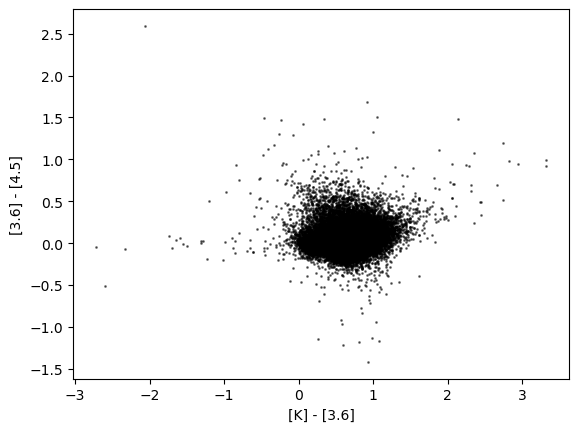

In [50]:
cat_spitzer.plot_CCD('K', '3.6', '3.6', '4.5', color='k', alpha=0.5, s=1)

<Axes: xlabel='[K] - [3.6]', ylabel='[4.5] - [5.8]'>

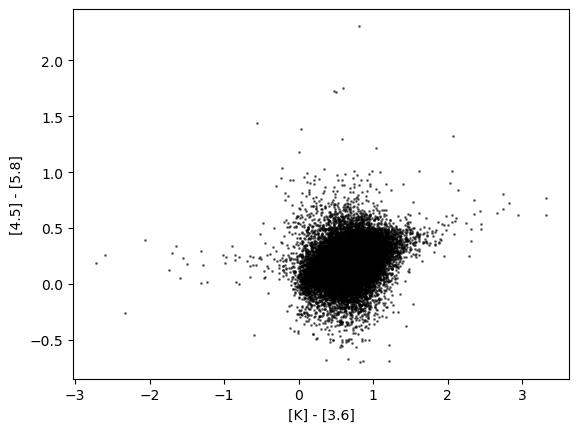

In [51]:
cat_spitzer.plot_CCD('K', '3.6', '4.5', '5.8', color='k', alpha=0.5, s=1)

/red/adamginsburg/repos/mpl_plot_templates/mpl_plot_templates/adaptive_param_plot.py:129: UserWarning: The following kwargs were not used by contour: 'markersize'
  con = axis.contour(cx,cy,H.T,levels=levels,norm=norm,cmap=cmap,**kwargs)


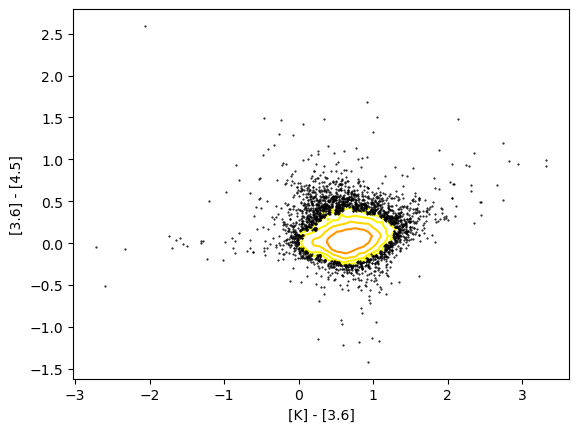

In [52]:
ax = plt.subplot()
#cat_spitzer.plot_CCD('K', '3.6', '3.6', '4.5', color='red', s=2)
cat_spitzer.plot_contour_CCD('K', '3.6', '3.6', '4.5', threshold=15)
#ax.set_ylim(-2, 3)

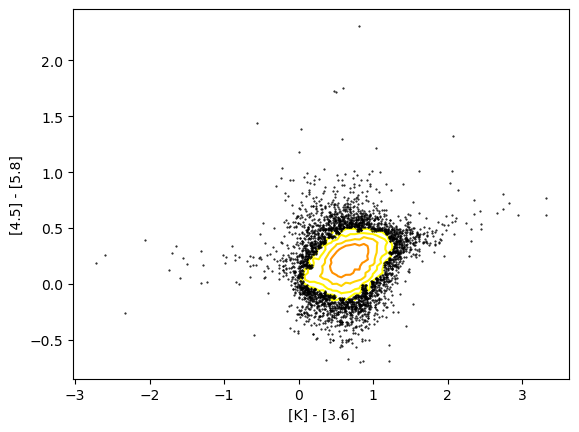

In [53]:
ax = plt.subplot()
#cat_spitzer.plot_CCD('K', '3.6', '3.6', '4.5', color='red', s=2)
cat_spitzer.plot_contour_CCD('K', '3.6', '4.5', '5.8', threshold=15)
#ax.set_ylim(-2, 3)

<Axes: xlabel='[J] - [K]', ylabel='[J]'>

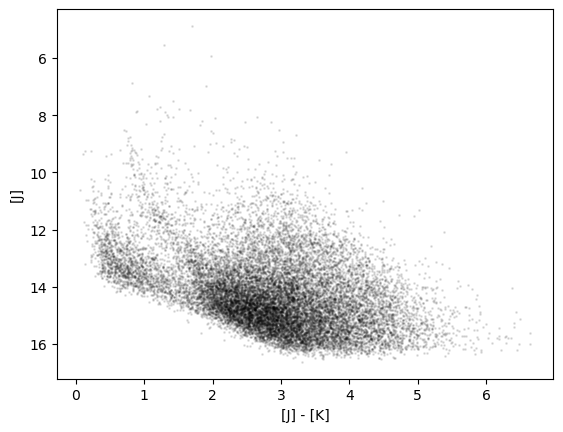

In [54]:
ax = plt.subplot()
cat_spitzer.plot_CMD('J', 'K', 'J', color='k', alpha=0.1, s=1, ax=ax)
#ax.set_xlim(2.5, 7)

<Axes: xlabel='[H] - [K]', ylabel='[H]'>

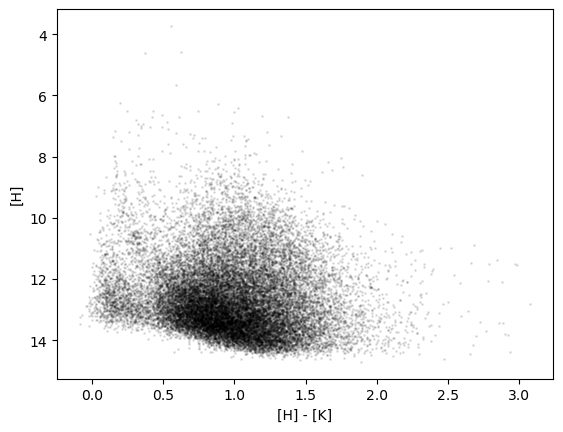

In [55]:
ax = plt.subplot()
cat_spitzer.plot_CMD('H', 'K', 'H', color='k', alpha=0.1, s=1, ax=ax)
#ax.set_xlim(2.5, 7)

In [56]:
cat_jwst = make_cat_use()

In [57]:
np.sum(cat_jwst.catalog['qfit_f405n'] > 0.4)

0

(0.0, 4.0)

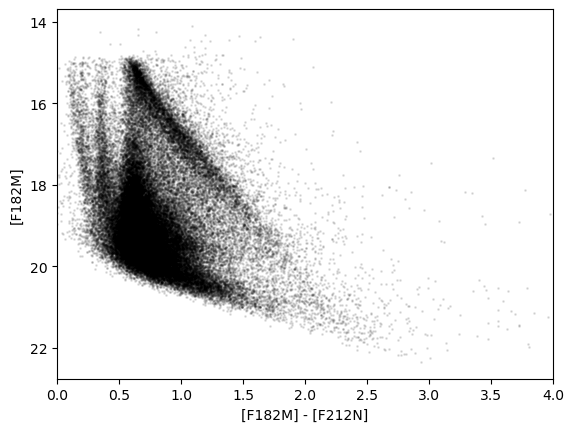

In [58]:
cat_jwst.plot_CMD('f182m', 'f212n', 'f182m', color='k', alpha=0.1, s=1)
plt.xlim(0, 4)

In [59]:
cat_cut = GlimpseCatalog(cat_spitzer.catalog[cat_spitzer.color('H', 'K') > 0.5])
#cat_cut.catalog

In [60]:
bc2_cutout = Cutout(coord_BC2, l=width, w=length)
bc2_cut = bc2_cutout.get_cutout('/orange/adamginsburg/cmz/galacticbar/bania2/spitzer/GLM_00300+0000_mosaic_I4.fits')
cutout_reg = bc2_cutout.get_cutout_region(frame='galactic')
cat_reg = GlimpseCatalog(cat_cut.catalog[cat_cut.get_region_mask([cutout_reg], bc2_cut.wcs)])

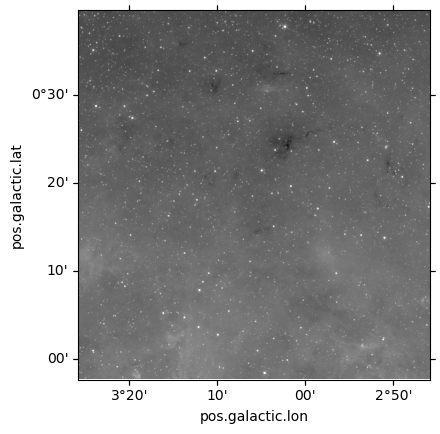

In [107]:
ax = plt.subplot(projection=bc2_cut.wcs)
ax.imshow(bc2_cut.data, origin='lower', cmap='gray', norm=simple_norm(bc2_cut.data, stretch='log', max_percent=99.99))

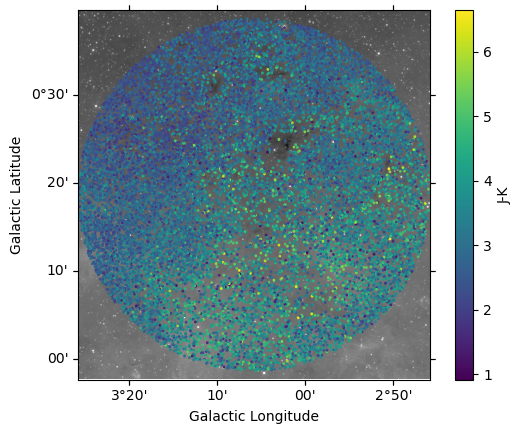

In [61]:
ax = plt.subplot(projection=bc2_cut.wcs)
ax.imshow(bc2_cut.data, origin='lower', cmap='gray', norm=simple_norm(bc2_cut.data, stretch='log', max_percent=99.99))
xlim = ax.get_xlim()
ylim = ax.get_ylim()
im = ax.scatter(cat_reg.coords.galactic.l, cat_reg.coords.galactic.b, transform=ax.get_transform('world'), s=1, c=cat_reg.color('J', 'K'), cmap='viridis')
ax.set_xlim(xlim)
ax.set_ylim(ylim)
plt.colorbar(im, label='J-K')
ax.set_xlabel('Galactic Longitude')
ax.set_ylabel('Galactic Latitude')

/red/adamginsburg/repos/mpl_plot_templates/mpl_plot_templates/adaptive_param_plot.py:129: UserWarning: The following kwargs were not used by contour: 'markersize'
  con = axis.contour(cx,cy,H.T,levels=levels,norm=norm,cmap=cmap,**kwargs)


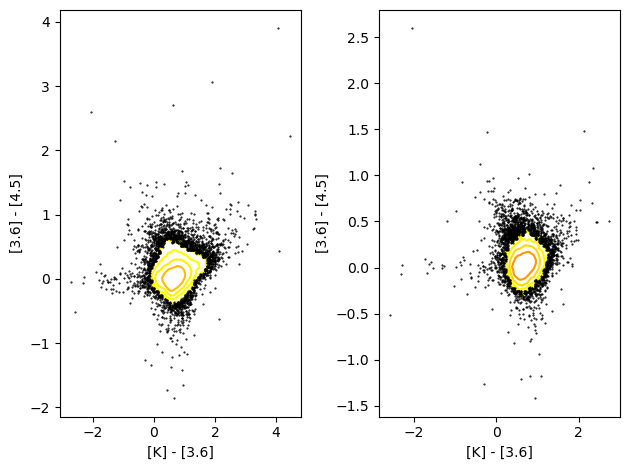

In [37]:
ax = plt.subplot(121)
cat_spitzer.plot_contour_CCD('K', '3.6', '3.6', '4.5', threshold=15, ax=ax)

ax = plt.subplot(122)
#cat_spitzer.plot_CCD('K', '3.6', '3.6', '4.5', color='red', s=2)
cat_reg.plot_contour_CCD('K', '3.6', '3.6', '4.5', threshold=15, ax=ax)
#ax.set_ylim(-2, 3)
plt.tight_layout()

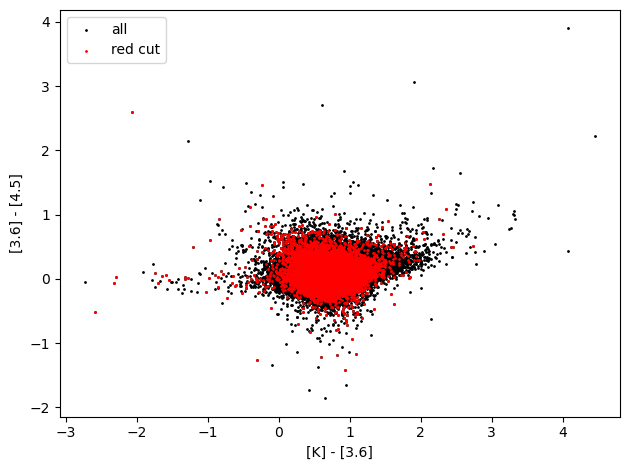

In [38]:
ax = plt.subplot(111)
cat_spitzer.plot_CCD('K', '3.6', '3.6', '4.5', ax=ax, s=1, color='k', label='all')

#ax = plt.subplot(122)
#cat_spitzer.plot_CCD('K', '3.6', '3.6', '4.5', color='red', s=2)
cat_reg.plot_CCD('K', '3.6', '3.6', '4.5', ax=ax, s=1, color='red', label='red cut')
#ax.set_ylim(-2, 3)
plt.tight_layout()
plt.legend()

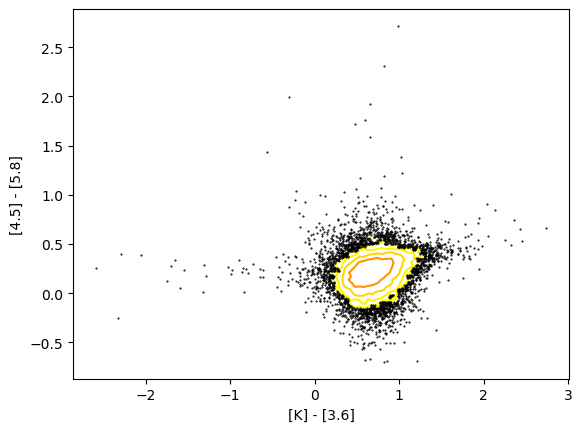

In [39]:
ax = plt.subplot()
#cat_spitzer.plot_CCD('K', '3.6', '3.6', '4.5', color='red', s=2)
cat_reg.plot_contour_CCD('K', '3.6', '4.5', '5.8', threshold=15)
#ax.set_ylim(-2, 3)

In [40]:
# J, H, K, 3.6, 4.5, 5.8, 8.0
bands = ['J', 'H', 'K', '3.6', '4.5', '5.8', '8.0']
band_combinations = [('J', 'H'), ('J', 'K'), ('J', '3.6'), ('J', '4.5'), ('J', '5.8'), ('J', '8.0'), ('H', 'K'), ('H', '3.6'), ('H', '4.5'), ('H', '5.8'), ('H', '8.0'), ('K', '3.6'), ('K', '4.5'), ('K', '5.8'), ('K', '8.0'), ('3.6', '4.5'), ('3.6', '5.8'), ('3.6', '8.0'), ('4.5', '5.8'), ('4.5', '8.0'), ('5.8', '8.0')]
color_combinations = [(band1, band2, band3, band4) for band1, band2 in band_combinations for band3, band4 in band_combinations if band1 != band3 and band2 != band4]
len(color_combinations)

280

In [41]:
280/20

14.0

In [42]:
#fig, axes = plt.subplots(20, 14, figsize=(20, 20))
#
#for i, (band1, band2, band3, band4) in enumerate(color_combinations):
#    ax = axes.flat[i]
#    cat_spitzer.plot_CCD(band1, band2, band3, band4, ax=ax, color='k', alpha=0.1, s=1)
#
#plt.tight_layout()

In [43]:
#fig, axes = plt.subplots(20, 14, figsize=(20, 20))
#
#for i, (band1, band2, band3, band4) in enumerate(color_combinations):
#    ax = axes.flat[i]
#    cat_reg.plot_CCD(band1, band2, band3, band4, ax=ax, color='k', alpha=0.1, s=1)
#
#plt.tight_layout()

In [44]:
from astroquery.xmatch import XMatch

In [67]:
XMatch.clear_cache()


In [73]:
coord_BC2 = SkyCoord(3.0970501246, 0.3112008170, unit=(u.deg, u.deg), frame='galactic')
reg_alt = regions.CircleSkyRegion(center=coord_BC2, radius=20*u.arcmin)

tbl = XMatch.query(cat1='II/316/gps6', cat2='II/293/glimpse', area=reg_alt, max_distance=1*u.arcsec, get_query_payload=True)

In [83]:
tbl = Table.read('/orange/adamginsburg/jwst/cloudc/catalogs/1738094020879A.csv')
tbl.rename_column('jAperMag3', 'Jmag')
tbl.rename_column('hAperMag3', 'Hmag')
tbl.rename_column('k_1AperMag3', 'Kmag')
tbl.rename_column('ra', 'RAJ2000')
tbl.rename_column('dec', 'DEJ2000')
tbl[:3]

angDist,JName,RAJ2000,DEJ2000,Jmag,Hmag,Kmag,k_2AperMag3,h2AperMag3,jAperMag3Err,hAperMag3Err,k_1AperMag3Err,k_2AperMag3Err,h2AperMag3_1,sourceID,mode,epoch,mergedClass,GLIMPSE,RAdeg,DEdeg,errHalfMaj,errHalfMin,errPosAng,3.6mag,4.5mag,5.8mag,8.0mag,e_3.6mag,e_4.5mag,e_5.8mag,e_8.0mag,C,F(3.6),e_F(3.6),F(4.5),e_F(4.5),F(5.8),e_F(5.8),F(8.0),e_F(8.0),q_3.6mag,q_4.5mag,q_5.8mag,q_8.0mag
float64,str19,float64,float64,float64,float64,float64,int64,int64,float64,float64,float64,int64,int64,int64,int64,float64,int64,str17,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,str1,float64,float64,float64,float64,float64,float64,float64,float64,str8,str8,str8,str8
0.246814,J175231.55-262307.8,268.131499,-26.385512,18.045,15.11,13.647,--,--,0.057,0.01,0.006,--,--,438566407070,1,2007.3267,-1,G002.9737+00.0027,268.131455,-26.385568,0.3,0.3,90,12.141,12.293,11.88,--,0.087,0.122,0.225,--,C,3.908,0.3136,2.174,0.244,2.035,0.4224,--,--,00100600,00000400,00000000,--
0.393333,J175230.78-262309.5,268.128271,-26.385985,15.538,14.42,13.776,--,--,0.006,0.005,0.007,--,--,438566407170,1,2007.3267,-1,G002.9718+00.0049,268.128262,-26.386094,0.3,0.3,90,13.2,13.176,--,--,0.073,0.125,--,--,C,1.475,0.09979,0.9644,0.1109,--,--,--,--,00000140,00000000,--,--
0.036114,J175232.23-262302.6,268.134299,-26.384068,15.142,12.335,10.958,--,--,0.005,0.001,0.001,--,--,438566407580,1,2007.3267,-1,G002.9763+00.0013,268.13431,-26.38407,0.3,0.3,90,9.929,9.937,9.692,9.822,0.034,0.045,0.046,0.047,C,30.0,0.9299,19.04,0.7948,15.27,0.6481,7.557,0.3246,00000000,00004040,00000000,00008000


In [85]:
tbl_cat = GlimpseCatalog(tbl)
tbl_cat.catalog[:3]

angDist,JName,RAJ2000,DEJ2000,Jmag,Hmag,Kmag,k_2AperMag3,h2AperMag3,jAperMag3Err,hAperMag3Err,k_1AperMag3Err,k_2AperMag3Err,h2AperMag3_1,sourceID,mode,epoch,mergedClass,GLIMPSE,RAdeg,DEdeg,errHalfMaj,errHalfMin,errPosAng,3.6mag,4.5mag,5.8mag,8.0mag,e_3.6mag,e_4.5mag,e_5.8mag,e_8.0mag,C,F(3.6),e_F(3.6),F(4.5),e_F(4.5),F(5.8),e_F(5.8),F(8.0),e_F(8.0),q_3.6mag,q_4.5mag,q_5.8mag,q_8.0mag
float64,str19,float64,float64,float64,float64,float64,int64,int64,float64,float64,float64,int64,int64,int64,int64,float64,int64,str17,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,str1,float64,float64,float64,float64,float64,float64,float64,float64,str8,str8,str8,str8
0.246814,J175231.55-262307.8,268.131499,-26.385512,18.045,15.11,13.647,--,--,0.057,0.01,0.006,--,--,438566407070,1,2007.3267,-1,G002.9737+00.0027,268.131455,-26.385568,0.3,0.3,90,12.141,12.293,11.88,--,0.087,0.122,0.225,--,C,3.908,0.3136,2.174,0.244,2.035,0.4224,--,--,00100600,00000400,00000000,--
0.393333,J175230.78-262309.5,268.128271,-26.385985,15.538,14.42,13.776,--,--,0.006,0.005,0.007,--,--,438566407170,1,2007.3267,-1,G002.9718+00.0049,268.128262,-26.386094,0.3,0.3,90,13.2,13.176,--,--,0.073,0.125,--,--,C,1.475,0.09979,0.9644,0.1109,--,--,--,--,00000140,00000000,--,--
0.036114,J175232.23-262302.6,268.134299,-26.384068,15.142,12.335,10.958,--,--,0.005,0.001,0.001,--,--,438566407580,1,2007.3267,-1,G002.9763+00.0013,268.13431,-26.38407,0.3,0.3,90,9.929,9.937,9.692,9.822,0.034,0.045,0.046,0.047,C,30.0,0.9299,19.04,0.7948,15.27,0.6481,7.557,0.3246,00000000,00004040,00000000,00008000


(20.0, 11.5)

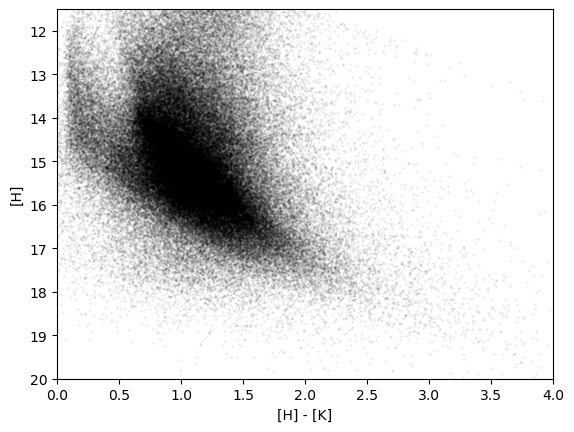

In [93]:
ax = plt.subplot()
tbl_cat.plot_CMD('H', 'K', 'H', color='k', alpha=0.05, s=1, ax=ax)
ax.set_xlim(0, 4)
ax.set_ylim(20, 11.5)

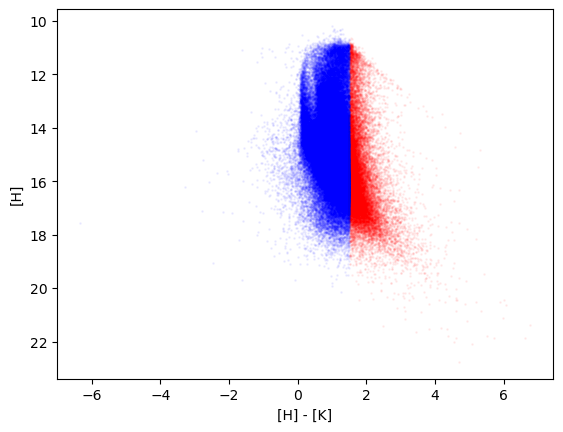

In [133]:
ax = plt.subplot()
tbl_red = GlimpseCatalog(tbl_cat.catalog[tbl_cat.color('H', 'K') > 1.5])
tbl_red.plot_CMD('H', 'K', 'H', color='r', alpha=0.05, s=1, ax=ax)
tbl_blue = GlimpseCatalog(tbl_cat.catalog[tbl_cat.color('H', 'K') < 1.5])
tbl_blue.plot_CMD('H', 'K', 'H', color='b', alpha=0.05, s=1, ax=ax)
plt.gca().invert_yaxis()

/red/adamginsburg/repos/mpl_plot_templates/mpl_plot_templates/adaptive_param_plot.py:129: UserWarning: The following kwargs were not used by contour: 'markersize'
  con = axis.contour(cx,cy,H.T,levels=levels,norm=norm,cmap=cmap,**kwargs)


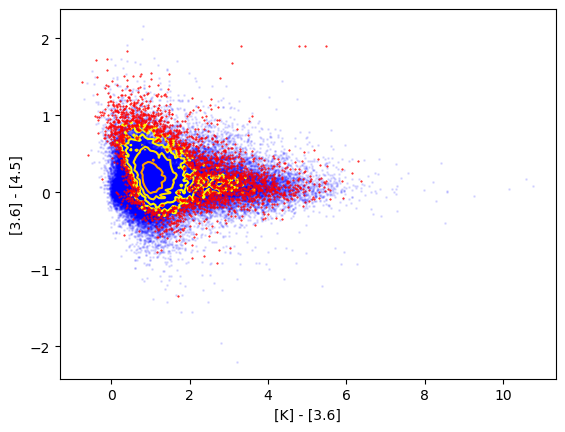

In [118]:
tbl_blue.plot_CCD('K', '3.6', '3.6', '4.5', color='blue', s=1, alpha=0.1)
tbl_red.plot_contour_CCD('K', '3.6', '3.6', '4.5', color='red', s=1, threshold=5)


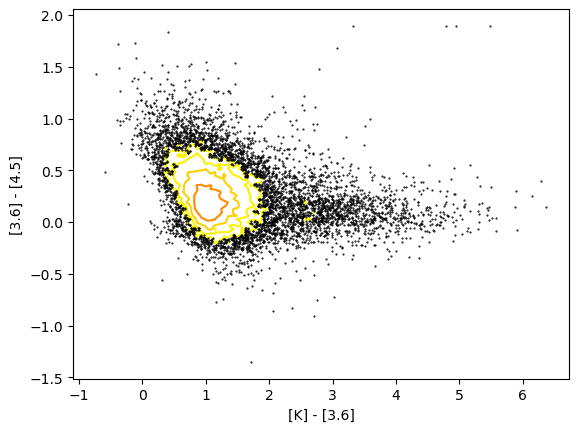

In [119]:
tbl_red.plot_contour_CCD('K', '3.6', '3.6', '4.5', threshold=10)

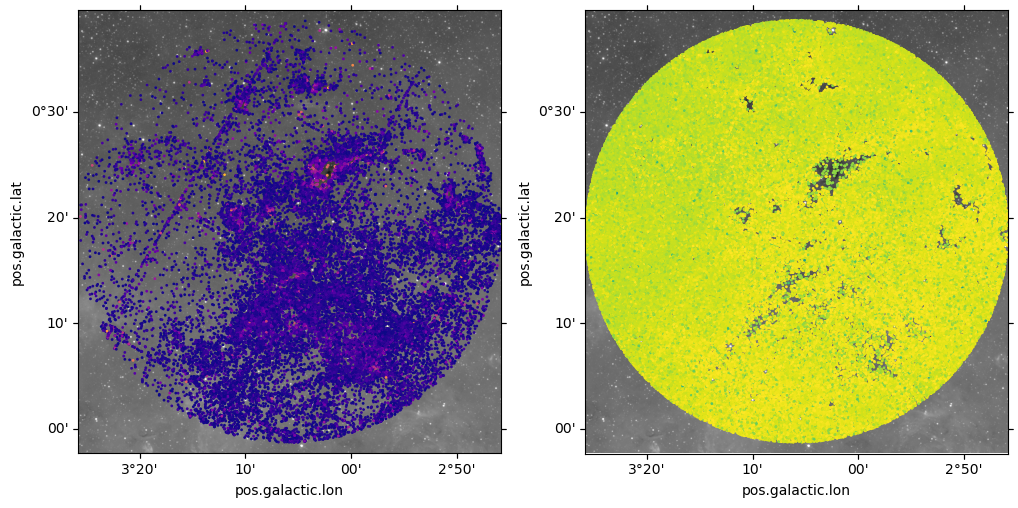

In [120]:
fig = plt.figure(figsize=(12, 6))
ax = plt.subplot(121, projection=bc2_cut.wcs)
ax.imshow(bc2_cut.data, origin='lower', cmap='gray', norm=simple_norm(bc2_cut.data, stretch='log', max_percent=99.99))
xlim = ax.get_xlim()
ylim = ax.get_ylim()
im = ax.scatter(tbl_red.coords.galactic.l, tbl_red.coords.galactic.b, transform=ax.get_transform('world'), s=1, c=tbl_red.color('H', 'K'), cmap='plasma')

ax = plt.subplot(122, projection=bc2_cut.wcs)
ax.imshow(bc2_cut.data, origin='lower', cmap='gray', norm=simple_norm(bc2_cut.data, stretch='log', max_percent=99.99))
xlim = ax.get_xlim()
ylim = ax.get_ylim()
im = ax.scatter(tbl_blue.coords.galactic.l, tbl_blue.coords.galactic.b, transform=ax.get_transform('world'), s=1, c=tbl_blue.color('H', 'K'), cmap='viridis')

/red/adamginsburg/repos/mpl_plot_templates/mpl_plot_templates/adaptive_param_plot.py:129: UserWarning: The following kwargs were not used by contour: 'markersize'
  con = axis.contour(cx,cy,H.T,levels=levels,norm=norm,cmap=cmap,**kwargs)


(-0.5, 2.0)

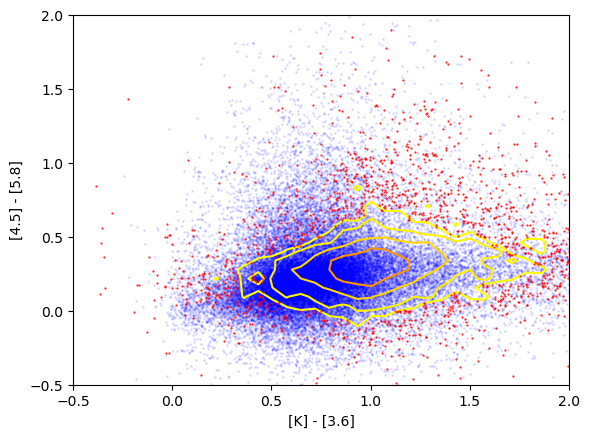

In [132]:
ax = plt.subplot()
tbl_blue.plot_CCD('K', '3.6', '4.5', '5.8', color='blue', s=1, alpha=0.1, ax=ax)
tbl_red.plot_contour_CCD('K', '3.6', '4.5', '5.8', ax=ax, threshold=10, color='r', s=1)
ax.set_xlim(-0.5, 2)
ax.set_ylim(-0.5, 2)
# what do ices do in CC space? 